In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
masses = [
    "MX_700_MY_300",
    "MX_800_MY_300",
    "MX_800_MY_350",
    "MX_900_MY_300",
    "MX_900_MY_400",
    "MX_1000_MY_300",
    "MX_1000_MY_450",
    "MX_1200_MY_500",
]

path = "/store/user/ekoenig/8BAnalysis/NTuples/2018/training/sig/"
signal = Tree([
    f"{path}/{mass}/split_0_training_sig.root"
    for mass in masses
])

100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


In [4]:
def get_reco(jet_p4, perm):
    p4 = jet_p4[perm]

    h_p4 = p4[:,::2] + p4[:,1::2]
    y_p4 = h_p4[:,::2] + h_p4[:,1::2]
    x_p4 = y_p4[:,0] + y_p4[:,1]

    y_rank = ak_rank( y_p4.pt, axis=1 )
    x_yy_order = ak.argsort(y_rank, ascending=True)

    y_h_rank = ak.unflatten(
            np.repeat(y_rank, 2),
            ak.count(h_p4.pt,axis=1),
        )
    h_rank = ak_rank( h_p4.pt, axis=1 )
    x_yy_4h_order = ak.argsort( 10*y_h_rank + h_rank, ascending=True )

    y_h_j_rank = ak.unflatten(
            np.repeat(y_h_rank, 2),
            ak.count(p4.pt,axis=1),
        )
    j_rank = ak_rank(p4.pt, axis=1)
    x_yy_4h_8b_order = ak.argsort( 100*y_h_j_rank + j_rank, ascending=True)

    y_p4_ordered = y_p4[x_yy_order]
    h_p4_ordered = h_p4[x_yy_4h_order]
    j_p4_ordered = p4[x_yy_4h_8b_order]
    

    return x_p4, y_p4_ordered, h_p4_ordered, j_p4_ordered

In [ ]:
def 

In [4]:
module = fc.eightb.preselection.t8btag_minmass
model = eightb.models.yy_quadh_bkg10_allsig

In [5]:
altfile='{base}'
feynnet_qcd = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile)])
orignal_qcd = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile)])

100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


In [19]:
orignal_qcd.apply(lambda t : eightb.load_yy_quadh_ranker(t, model.path))


[None]

In [20]:
feynnet_qcd.apply(lambda t : eightb.load_yy_quadh_ranker(t, model.path+'/feynnet_output/'))


[None]

In [8]:
for qcd in orignal_qcd:
    qcd.sample = 'Org NN QCD'

In [9]:
for qcd in feynnet_qcd:
    qcd.sample = 'FeynNet QCD'

100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


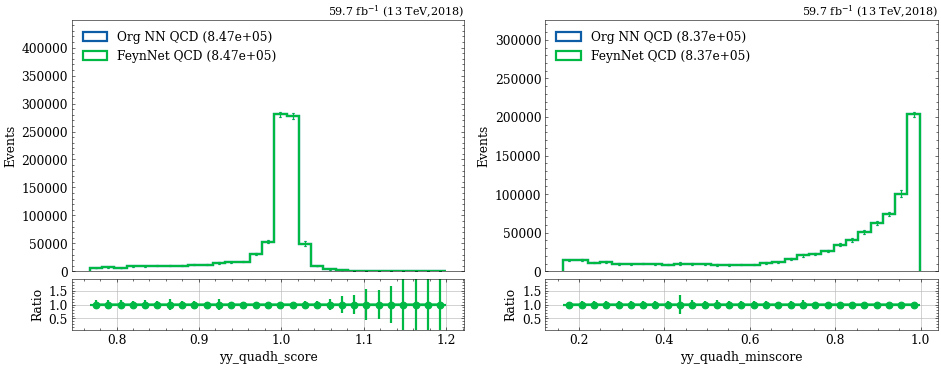

In [10]:
study.quick(
    orignal_qcd + feynnet_qcd,
    stacked=False,
    h_color=None,
    legend=True,
    varlist=['yy_quadh_score','yy_quadh_minscore'],

    ratio=True
)

100%|██████████| 6/6 [00:02<00:00,  2.00it/s]


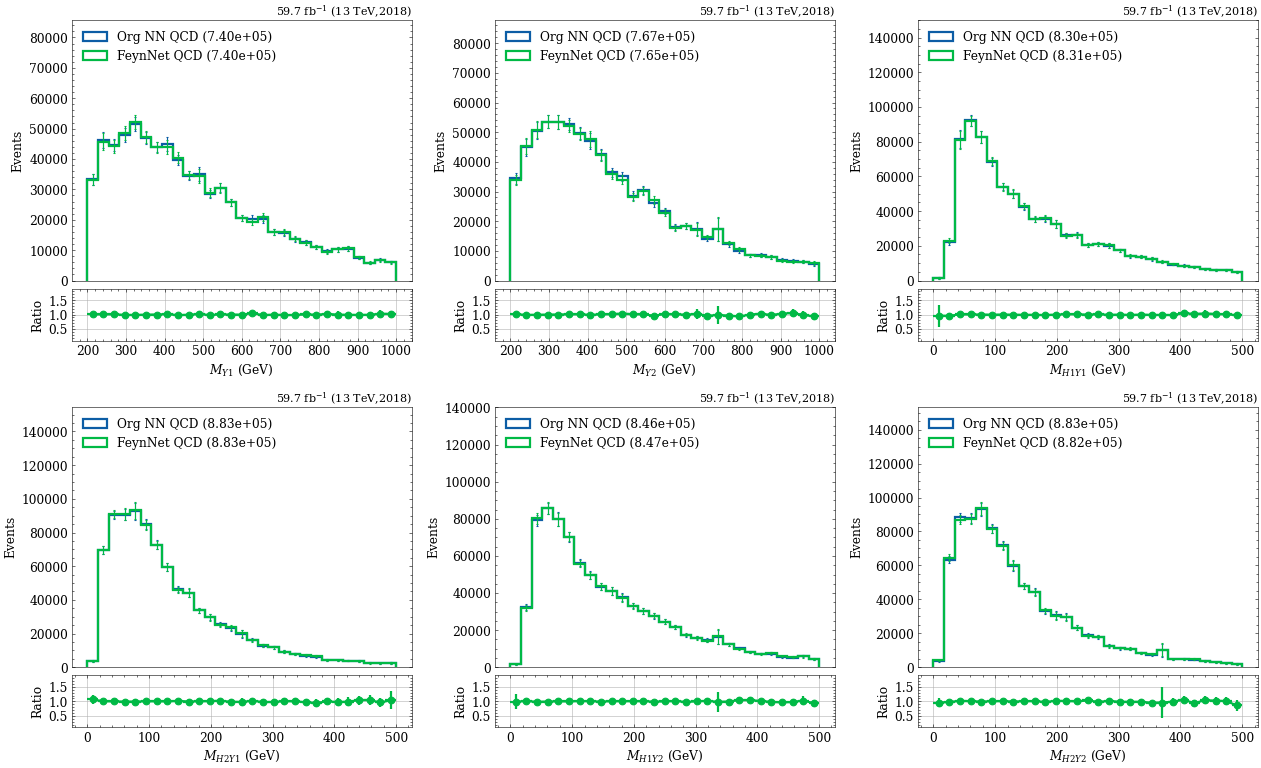

In [11]:
study.quick(
    orignal_qcd + feynnet_qcd,
    stacked=False,
    h_color=None,
    legend=True,
    varlist=['Y1_m','Y2_m','H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],

    ratio=True
)

0.9433631242343272


(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7f12205c2760>]>])

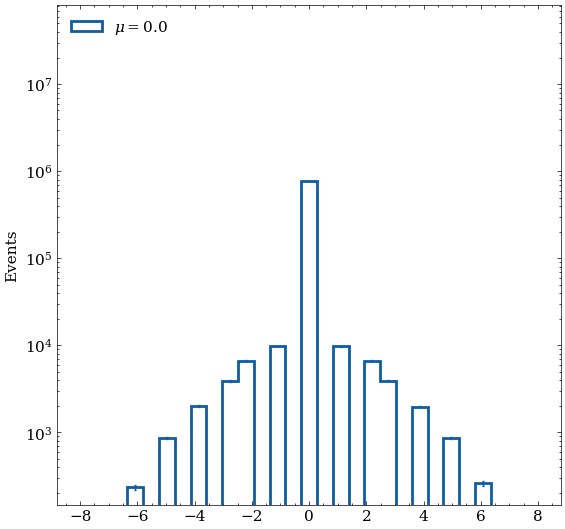

In [21]:
variable = 'assignment_combs'
org = orignal_qcd[0][variable]
new = feynnet_qcd[0][variable]
res = (new - org)

mask = np.abs(res) == 0
print(np.mean(mask))
hist_multi([res], h_label_stat='mean', legend=True, bins=(-8,8,30), log=True)

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7f1224f9cc70>]>])

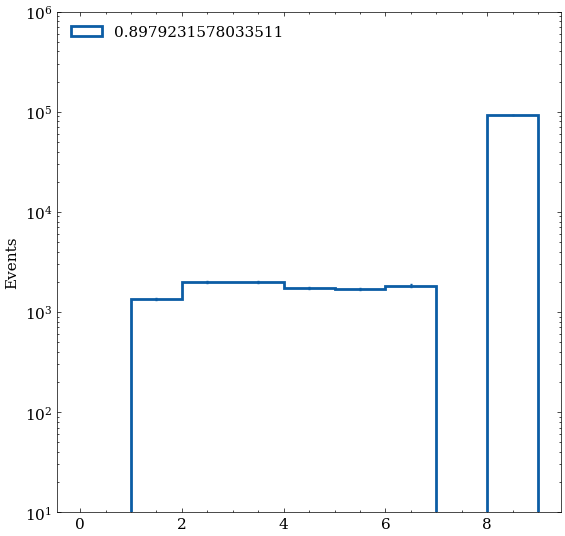

In [31]:
n_same = np.sum(mask, axis=-1)
hist_multi([n_same], log=True, h_label_stat=lambda h : f'{h.histo[-1]/np.sum(h.histo)}', legend=True, ylim=(1e1, 1e6))

In [40]:
variable = 'assignment_combs'
org = orignal_qcd[0][variable]
new = feynnet_qcd[0][variable]

In [44]:
from utils.classUtils.Feynman import Feynman
x_yy_4h_8j = Feynman('x').decays(
    Feynman('y').decays(
        Feynman('h').decays('j','j'),
        Feynman('h').decays('j','j')
    ),

    Feynman('y').decays(
        Feynman('h').decays('j','j'),
        Feynman('h').decays('j','j')
    ),
)
x_yy_4h_8j.build_diagram()

In [47]:
new[n_same==6][0], org[n_same==6][0]

(<Array [0, 1, 3, 7, 2, 5, 4, 6] type='8 * float64'>,
 <Array [0, 3, 1, 7, 2, 5, 4, 6] type='8 * float64'>)

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7f121a849ca0>]>])

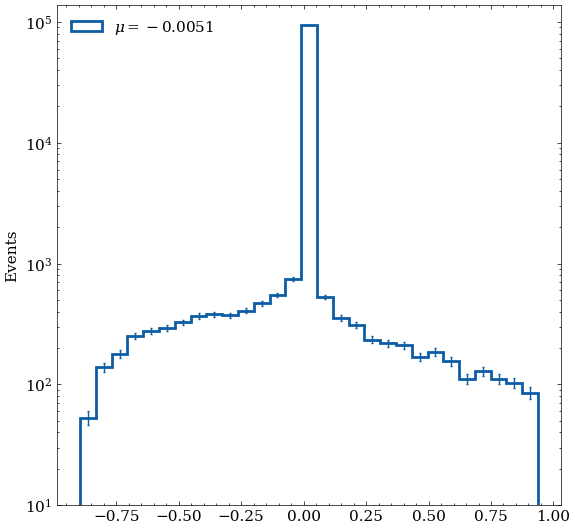

In [57]:
variable = 'higgs_m'
org = orignal_qcd[0][variable]
new = feynnet_qcd[0][variable]

org = np.sqrt( np.sum( (org-125)**2, axis=-1) )
new = np.sqrt( np.sum( (new-125)**2, axis=-1) )

res = ((new - org)/org)

hist_multi([res], h_label_stat='mean', legend=True, log=True, ylim=(1e1, -1))

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

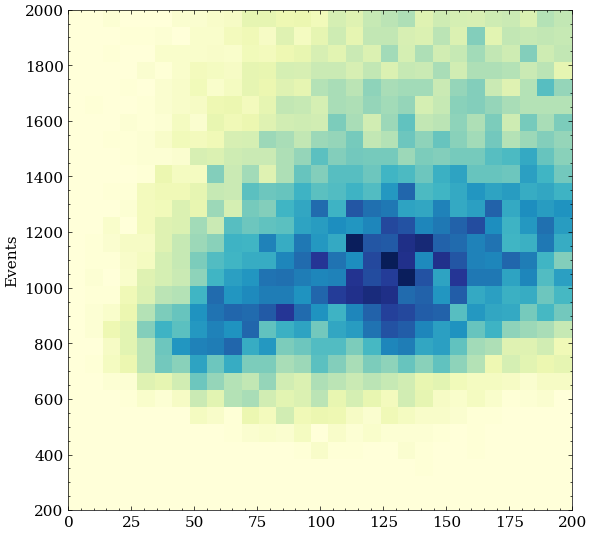

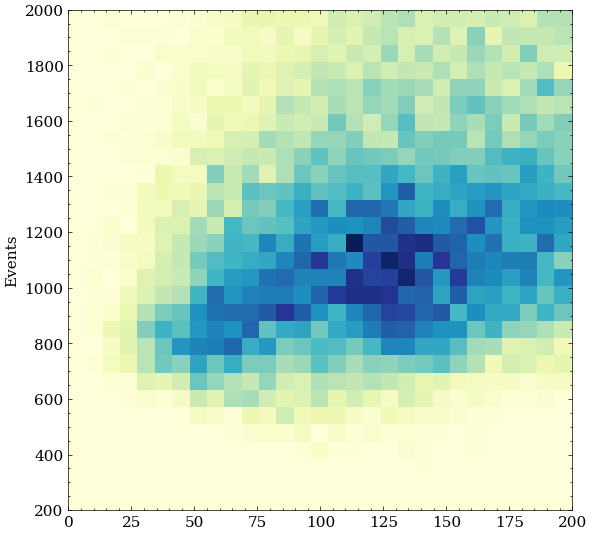

In [65]:
hist2d_multi([org], [orignal_qcd[0]['X_m']], x_bins=(0,200,30), y_bins=(200,2000,30))
hist2d_multi([new], [feynnet_qcd[0]['X_m']], x_bins=(0,200,30), y_bins=(200,2000,30))

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7f121aa6a640>, <utils.plotUtils.histogram.Histo object at 0x7f1218f331c0>]>])

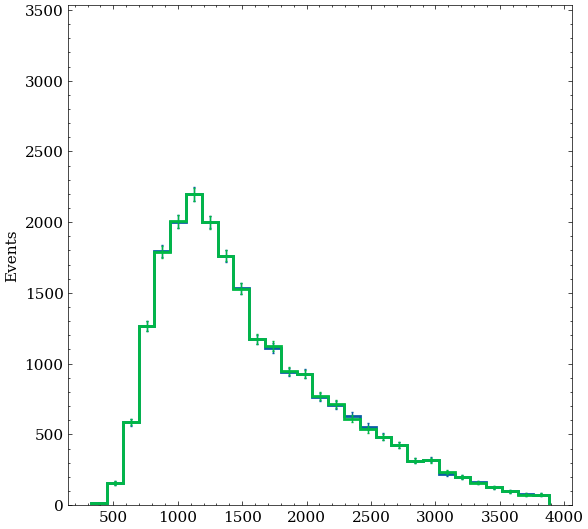

In [72]:
hist_multi([orignal_qcd[0]['X_m'][orignal_qcd[0]['H1Y1_m']<125], feynnet_qcd[0]['X_m'][feynnet_qcd[0]['H1Y1_m']<125]])